# Grid cell score encoding model development notebook

Imports

In [1]:
%matplotlib inline

import sys
import os
import shutil
import time
import traceback
from pathlib import Path
import h5py
import json
import pickle
from types import SimpleNamespace
from joblib import delayed, Parallel

from scipy import signal, stats, spatial, ndimage
from scipy.interpolate import interp1d
from sklearn import linear_model as lm
import statsmodels.api as sm

from skimage import draw 
from skimage.transform import rotate

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', palette='muted')

## added TreeMazeanalyses folder using the following command
## conda develop /home/alexgonzalez/Documents/TreeMazeAnalyses2
import TreeMazeAnalyses2.Utils.robust_stats as rs
import TreeMazeAnalyses2.Utils.filter_functions as filter_funcs 
import TreeMazeAnalyses2.Pre_Processing.pre_process_functions as pp_funcs

from TreeMazeAnalyses2.Analyses.subject_info import SubjectInfo, SubjectSessionInfo
from TreeMazeAnalyses2.Analyses import spatial_functions as spatial_funcs
import TreeMazeAnalyses2.Analyses.open_field_functions as of_funcs
from TreeMazeAnalyses2.Analyses.spike_functions import smooth_bin_spikes

from importlib import reload

import ipywidgets as widgets
from ipywidgets import interact, fixed, interact_manual


### Load Data

In [2]:
subject_id = 'Li'
session = 'Li_OF_061218'
#subject_info = SubjectInfo(subject_id, overwrite=True)
subject_info = SubjectInfo(subject_id)
session_info = SubjectSessionInfo(subject_id,session)
track_params = SimpleNamespace(**session_info.task_params)
n_units = session_info.n_units
print(session_info)
session_info.print_task_params()


number of units in session 32

Session Information for subject Li, session Li_OF_061218
Number of curated units: 32
Methods listed below can be executed with get_{method}(), eg. get_spikes():
  -> track_data. Executed = True
  -> time. Executed = True
  -> spikes. Executed = True
  -> binned_spikes. Executed = True
  -> fr. Executed = True
  -> spike_maps. Executed = True
  -> fr_maps. Executed = True
  -> scores. Executed = True
  -> lnp_scores. Executed = False

To run all analyses use run_analyses().


Task/track and analysis parameters. 

  -> time_step: 0.02
  -> x_pix_lims: [100, 650]
  -> y_pix_lims: [100, 500]
  -> x_pix_bias: -380
  -> y_pix_bias: -280
  -> vt_rate: 0.016666666666666666
  -> xy_pix_rot_rad: 1.6507963267948966
  -> x_pix_mm: 3.7790697674418605
  -> y_pix_mm: 3.265765765765766
  -> x_mm_bias: 20
  -> y_mm_bias: 650
  -> x_mm_lims: [-630, 630]
  -> y_mm_lims: [-60, 1350]
  -> x_cm_lims: [-63, 63]
  -> y_cm_lims: [-6, 135]
  -> mm_bin: 30
  -> cm_bin: 3
  -> max_s

In [3]:
session_info.run_analyses(overwrite=False)

Analysis scores not implemented.
Analysis lnp_scores not implemented.


In [4]:
binned_spks = session_info.get_binned_spikes()
fr = session_info.get_fr()
t_rs = session_info.get_time()
of_dat = session_info.get_track_data()

spike_maps = session_info.get_spike_maps()
fr_maps = session_info.get_fr_maps()

of_dat = SimpleNamespace(**of_dat)

### glimpse spatial maps

In [24]:
def plot_fr_map(unit):
    f, ax = plt.subplots()
    ax = sns.heatmap(fr_maps[unit], ax=ax, cbar_kws={'label':'Hz'})
    ax.invert_yaxis()
    ax.axis('equal')
    ax.axis('off')
    
_=interact(plot_fr_map, unit=widgets.IntSlider(min=0, max=n_units-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='unit', max=31), Output()), _dom_classes=('widget-interac…

## Code and functions to generate grid patterns.

We use a Moire grids to generate possible grid cells, modified from Blaire et al. JNeuro 2007.  These serve as the templates for the encoding grid cell model.

Essential functions:

The grid pattern at a given position $r = (x,y)$ is determined by a cosine grating model:
$$ G(r) = g\left( \sum_{k=0}^2 \text cos (w_k \centerdot (r-c) ) \right)$$
Where  $c = (x_0, y_0)$ is the spatial phase or centering of the pattern, and $g(x)$ is the gain function described below.

The vectors $w_k$ are defined as follows: 
$$\angle w_k = \theta - \frac{\pi}{3} \left( \frac{1}{2} -k \right)$$
$$|w_k| = w = \frac{1}{L} \frac{4\pi} {\sqrt 3}$$ 

Two important paramters in the above equations are $L$ which corresponds to the spatial spacing, and $\theta$ the angle or phase of the pattern.

The gain function $g(x)$ is defined to go from zero to 1:
$$ g(x) = \frac{e^{a(x-x_{min})}-1} { e^{ a(x_{max}-x_{min}) }-1 } = \frac{e^{a(x+1.5)}-1} {e^{4.5a}-1}$$

The parameter $a$ determines how sharp the fields are, the larger a is the 'pointier' the fields will be, while keeping the same spacing $L$. The sum of cosines as defined above has a minimum value of -1.5 and a max value of 3.


In [6]:
class g_points():
    def __init__(self, x, y, polar=False):
        
        if not isinstance(x, np.ndarray):
            x = np.array([x]).flatten()
        if not isinstance(y, np.ndarray):
            y = np.array([y]).flatten()
            
        assert len(x)==len(y), 'different lengths'
        
        self.n = len(x)
        if not polar:
            self.x = np.array(x)
            self.y = np.array(y)
            self.xy = np.column_stack((self.x,self.y))
            self.r, self.ang = self.polar()
        else:
            self.r = x
            self.ang = np.mod(y,2*np.pi)
            self.x, self.y = self.eu()
            self.xy = np.column_stack((self.x,self.y))
            
    def polar(self):
        r = np.sqrt(self.x**2 + self.y**2)
        ang = np.zeros(self.n)
        
        for ii in range(self.n):
            ang[ii] = np.math.atan2(self.y[ii], self.x[ii])
        ang = np.mod(ang, 2*np.pi)
        return r, ang
    
    def eu(self):
        x = self.r*np.cos(self.ang)
        y = self.r*np.sin(self.ang)
        return x, y
    
    def __add__(self, b):    
        return g_points(self.x+b.x, self.y+b.y)
    
    def __sub__(self, b):
        if isinstance(b, (int,float)):
            return g_points(self.x-b, self.y-b)
        
        if isinstance(b, (env_points, g_points)):
            return g_points(self.x-b.x, self.y-b.y)
        else:
            raise NotImplementedError
    
    def __rsub__(self, b):
        if isinstance(b, (int,float)):
            return g_points(b-self.x, b-self.y)
        
        if isinstance(b, (env_points, g_points)):
            return g_points(b.x-self.x, b.y-self.y)
        else:
            raise NotImplementedError
        
    def __mul__(self, b):
        if isinstance(b, (int,float, np.float, np.int)):
            return g_points(b*self.x,b*self.y)
        
        if isinstance(b, (env_points, g_points)):
            return b.x@self.x + b.y@self.y
        else:
            raise NotImplementedError
        
    def __rmul__(self, b):
        if isinstance(b, (int,float, np.float, np.int)):
            return g_points(b*self.x,b*self.y)
        elif isinstance(b, (env_points, g_points)):
            if self.n==b.n:
                return g_points(b.x*self.x,  b.y@self.y)
            if self.n==1 or b.n==1:
                return 
        else:
            raise NotImplementedError

    def __getitem__(self, i):
        if isinstance(i, (int, np.int,np.ndarray)):
            return g_points(self.x[i], self.y[i])
        else:
            raise NotImplementedError
            
    def __len__(self):
        return self.n
        
    def __str__(self):
        print( (self.x, self.y) ) 
        return ''
    
    
class env_points(g_points):
    def __init__(self, x, y, height=47, width=42, polar=False):
        
        if not isinstance(x, np.ndarray):
            x = np.array([x]).flatten()
        if not isinstance(y, np.ndarray):
            y = np.array([y]).flatten()
            
        assert len(x)==len(y), 'different lengths'
        
        self.n = len(x)
        self.width = width
        self.height = height
        
        if not polar:
            self.x = np.round(np.mod(x, self.width))
            self.y = np.round(np.mod(y, self.height))
            self.xy = np.column_stack((x,y))
            self.r, self.ang = self.polar()
        else:
            self.r = x
            self.ang = np.mod(y,2*np.pi)
            self.x, self.y = self.eu()
            self.xy = np.column_stack((x,y))
            
    def polar(self):
        r = np.sqrt(self.x**2 + self.y**2)
        ang = np.zeros(self.n)
        
        for ii in range(self.n):
            ang[ii] = np.math.atan2(self.y[ii], self.x[ii])
        ang = np.mod(ang, 2*np.pi)
        return r, ang
    
    def eu(self):
        x = np.round(self.r*np.cos(self.ang))
        y = np.round(self.r*np.sin(self.ang))
        return x, y
            
            
a=env_points([10,2],[3,9])
b = env_points(1,2)
print(a)
print(b*2)
print(a-b*3)

(array([10,  2]), array([3, 9]))

(array([2]), array([4]))

(array([ 7, -1]), array([-3,  3]))



In [7]:
class g_points():
    def __init__(self, x, y, polar=False):
        
        if not isinstance(x, np.ndarray):
            x = np.array([x]).flatten()
        if not isinstance(y, np.ndarray):
            y = np.array([y]).flatten()
            
        assert len(x)==len(y), 'different lengths'
        
        self.n = len(x)
        if not polar:
            self.x = np.array(x)
            self.y = np.array(y)
            self.xy = np.column_stack((self.x,self.y))
            self.r, self.ang = self.polar()
        else:
            self.r = x
            self.ang = np.mod(y,2*np.pi)
            self.x, self.y = self.eu()
            self.xy = np.column_stack((self.x,self.y))
            
    def polar(self):
        r = np.sqrt(self.x**2 + self.y**2)
        ang = np.zeros(self.n)
        
        for ii in range(self.n):
            ang[ii] = np.math.atan2(self.y[ii], self.x[ii])
        ang = np.mod(ang, 2*np.pi)
        return r, ang
    
    def eu(self):
        x = self.r*np.cos(self.ang)
        y = self.r*np.sin(self.ang)
        return x, y
    
    def __add__(self, b):    
        return g_points(self.x+b.x, self.y+b.y)
    
    def __sub__(self, b):
        if isinstance(b, (int,float)):
            return g_points(self.x-b, self.y-b)
        
        if isinstance(b, (env_points, g_points)):
            return g_points(self.x-b.x, self.y-b.y)
        else:
            raise NotImplementedError
    
    def __rsub__(self, b):
        if isinstance(b, (int,float)):
            return g_points(b-self.x, b-self.y)
        
        if isinstance(b, (env_points, g_points)):
            return g_points(b.x-self.x, b.y-self.y)
        else:
            raise NotImplementedError
        
        
    def __mul__(self, b):
        if isinstance(b, (int,float, np.float, np.int)):
            return g_points(b*self.x,b*self.y)
        
        if isinstance(b, (env_points, g_points)):
            return b.x@self.x + b.y@self.y
        else:
            raise NotImplementedError
        
    def __rmul__(self, b):
        if isinstance(b, (int,float, np.float, np.int)):
            return g_points(b*self.x,b*self.y)
        elif isinstance(b, (env_points, g_points)):
            if self.n==b.n:
                return g_points(b.x*self.x,  b.y@self.y)
            if self.n==1 or b.n==1:
                return 
        else:
            raise NotImplementedError

    def __getitem__(self, i):
        if isinstance(i, (int, np.int,np.ndarray)):
            return g_points(self.x[i], self.y[i])
        else:
            raise NotImplementedError
            
    def __len__(self):
        return self.n
        
    def __str__(self):
        print( (self.x, self.y) ) 
        return ''
    
class env_points():
    def __init__(self, x, y, height=47, width=42, polar=False):
        
        if not isinstance(x, np.ndarray):
            x = np.array([x]).flatten()
        if not isinstance(y, np.ndarray):
            y = np.array([y]).flatten()
            
        assert len(x)==len(y), 'different lengths'
        
        self.n = len(x)
        self.width = width
        self.height = height
        
        if not polar:
            self.x = np.round(np.mod(x, self.width))
            self.y = np.round(np.mod(y, self.height))
            self.xy = np.column_stack((x,y))
            self.r, self.ang = self.polar()
        else:
            self.r = x
            self.ang = np.mod(y,2*np.pi)
            self.x, self.y = self.eu()
            self.xy = np.column_stack((x,y))
            
    def polar(self):
        r = np.sqrt(self.x**2 + self.y**2)
        ang = np.zeros(self.n)
        
        for ii in range(self.n):
            ang[ii] = np.math.atan2(self.y[ii], self.x[ii])
        ang = np.mod(ang, 2*np.pi)
        return r, ang
    
    def eu(self):
        x = np.round(self.r*np.cos(self.ang))
        y = np.round(self.r*np.sin(self.ang))
        return x, y
    
    def __add__(self, b):    
        return env_points(self.x+b.x, self.y+b.y)
    
    def __sub__(self, b):
        return env_points(self.x-b.x, self.y-b.y)
    
    def __getitem__(self, i):
        if isinstance(i, (int, np.int,np.ndarray)):
            return g_points(self.x[i], self.y[i])
        else:
            raise NotImplementedError
    
    def __str__(self):
        print( (self.x, self.y) ) 
        return ''
        
    def __len__(self):
        return self.n
        
    def __str__(self):
        print( (self.x, self.y) ) 
        return ''


        
def gain_func(x, a=5/9, xmin=-1.5, xmax=3):
    c = a*(xmax-xmin)
    return (np.exp(a*(x-xmin)) - 1)/(np.exp(c)-1) 


def moire_theta_grid(r, c, l=30, theta=0, a=5/9):
    n_gratings = 3
    
    w = 1/l * 4*np.pi/np.sqrt(3) * np.ones(n_gratings) # 3 vecs w same length
    
    angs = theta - np.pi/3*(1/2-np.arange(n_gratings)) # the angles
    wk = g_points(w, angs, polar=True) # create object with the 3 vectos
    
    ph_k = (r.xy-c.xy) @ wk.xy.T
    cos_k = np.cos(ph_k)
    return gain_func(cos_k.sum(axis=1),a=a)
    
p = env_points
g = g_points

In [8]:
p = env_points
n=10
p1 = p(np.arange(n),np.zeros(n))
p2 = p(10,13)
p3 = p(2, np.pi, polar=True)
z = p1+p2+p3
print(z.r, z.ang)

[15.26433752 15.8113883  16.40121947 17.02938637 17.69180601 18.38477631
 19.10497317 19.84943324 20.61552813 21.40093456] [1.01914134 0.96525166 0.9151007  0.8685394  0.82537685 0.78539816
 0.74837805 0.7140907  0.68231655 0.65284663]


In [9]:
def plot_sim_grid_fr_map(l, theta, initial_pos, dims):
    x_mat,y_mat = np.meshgrid(np.arange(dims[1]), np.arange(dims[0]))
    gfr = moire_theta_grid(p(x_mat.flatten(), y_mat.flatten()), initial_pos, l, theta)
    plot_map(gfr.reshape(dims))
                              
def plot_map(map_):
    f, ax = plt.subplots()
    ax = sns.heatmap(map_, ax=ax)
    ax.invert_yaxis()
    ax.axis('equal')
    return

_=interact(plot_sim_grid_fr_map, 
         l=widgets.IntSlider(min=5, max=30, step=2, value=15), 
         theta=widgets.FloatSlider(min=0, max=np.pi/3, step=np.pi/36, value=0), 
         initial_pos=fixed(p(0,0)),
         dims=fixed((47,42)))


interactive(children=(IntSlider(value=15, description='l', max=30, min=5, step=2), FloatSlider(value=0.0, desc…

### evaluate the effect of parameter a in the gain

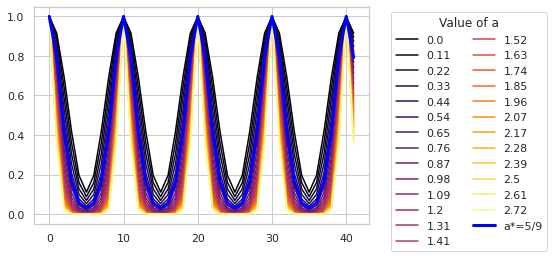

In [10]:
x_mat,y_mat = np.meshgrid(np.arange(42), np.arange(47))
r = p(x_mat.flatten(), y_mat.flatten())
c = p(0,0)
th = 0
lamb=10

cm = np.array(plt.get_cmap('inferno').colors)[::10]
n_cm = cm.shape[0]
a_range = np.linspace(0.001,np.e,n_cm) 
f,ax=plt.subplots()
for i, a in enumerate(a_range):
    gfr = moire_theta_grid(r, c, l=lamb, theta=th, a=a)
    ax.plot(gfr[:42], color=cm[i], label=np.around(a,2))


gfr = moire_theta_grid(r, c, l=lamb, theta=th, a=5/9)
_=ax.plot(gfr[:42], color='blue', label=f'a*=5/9', linewidth=3)
_=ax.legend(bbox_to_anchor=(1.05,1), ncol=2, title='Value of a')


[ 4 11  4]


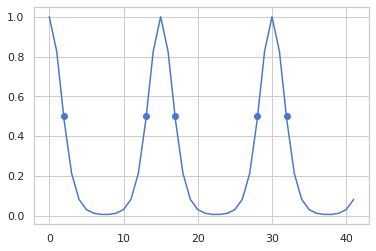

In [11]:
l=15
a = 1.1
gfr = moire_theta_grid(r, c, l=l, theta=th, a=a)

plt.plot(gfr[:42])
idx = np.argwhere(np.abs(gfr[:42]-0.5)<0.1).flatten()
plt.scatter(idx,[0.5]*len(idx))

print(np.diff(np.argwhere(np.abs(gfr[:42]-0.5)<0.1).flatten()[1:]))


In [12]:
def plot_sim_grid_fr_map(l, theta, a, initial_pos, dims):
    x_mat,y_mat = np.meshgrid(np.arange(dims[1]), np.arange(dims[0]))
    gfr = moire_theta_grid(p(x_mat.flatten(), y_mat.flatten()), initial_pos, l, theta, a)
    plot_map(gfr.reshape(dims))
                              
def plot_map(map_, ax=None):
    if ax is None:
        f, ax = plt.subplots()
    ax = sns.heatmap(map_, ax=ax)
    ax.invert_yaxis()
    ax.axis('equal')
    return ax.figure, ax

_=interact(plot_sim_grid_fr_map, 
         l=widgets.IntSlider(min=5, max=30, step=2, value=15),
         a=widgets.FloatSlider(min=0.0001,max=10,step=0.001, value=np.e),
         theta=widgets.FloatSlider(min=0, max=np.pi/3, step=np.pi/36, value=0), 
         initial_pos=fixed(p(0,0)),
         dims=fixed((47,42)))

interactive(children=(IntSlider(value=15, description='l', max=30, min=5, step=2), FloatSlider(value=0.0, desc…

increasing a makes fields smaller at the same spacing.

## Grid Cell simulations to test the model.
In simulations of grid cells below, the $G(r)$ essentially functions as the Poisson rate $\lambda_s(r)$, where $s$ represents signal and $r$ represents the spatial position. The probabilty of observing $k$ spikes can be described as:


$$ P[n_{signal-spikes}=k | r] = P[n_{signal-spikes}=k | \lambda_s(r) ] = \frac{\lambda_s(r) e^{-\lambda_s(r)}} {k!} $$

More concretely, the probability of observing at least one spike can be descibed as:


$$ P[n_{signal-spikes}>0 | \lambda_s(r)] = 1-P[n_{signal-spikes}=0 | \lambda_s(r) ] = 1 - e^{-\lambda_s(r)}$$


We can vary the noise in the model by defining an extra parameter $\lambda_n$, ($n$ representing noise) which is just a base rate for observing noise-spikes at any spatial position:


$$ P[n_{noise-spikes}=k | r] = P[n_{noise-spikes}=k | \lambda_n ] = \frac{\lambda_n e^{-\lambda_n}} {k!} $$


To make this more concrete, we define $p(noise-spike)$ as the base probability of observing at least one noise spike at a given time bin, and can derive $\lambda_n$ from that probability.


$$p(noise-spike)=P[n_{noise-spikes}>0| \lambda_n]=1-P[n_{noise-spikes}=0| \lambda_n]= 1 - e^{-\lambda_n} $$
$$ \lambda_n = - \text{ln} (1-p(noise-spike))$$

So, for $p(noise-spike)=0.1$, $\lambda_n = 0.1053$.


Finally, at any given spatial point, the probability of observing a spike is:

$$ P[n_{spikes}>0|r] = (1-P[n_{spikes}=0| \lambda_s(r) + \lambda_n]) =  1 - e^{-(\lambda_s(r)+\lambda_n)} $$

Hence, for a given signal to noise ratio defined as the ratio of signal at the peak of a moire field, and it's through. $\text{gSNR}= \frac{\lambda_s(peak) + \lambda_n}{\lambda_s(through) + \lambda_n}$, and because at the grid nodes $\lambda_s(peak)=G(peak)=1$ and $G(through) \approx 0$:


$$ \text{gSNR} = \frac{1+\lambda_n}{\lambda_n}$$


And for a given $\text{gSNR}>1$, we can also obtain a $\lambda_n$


$$\lambda_n = \frac{1}{\text{gSNR}-1}$$




Simulation Parameters
{'sim_gain': 0.5555555555555556, 'sim_l': 15, 'sim_theta': 0.7170001251436164, 'sim_spatial_phase_x': 23.501501501501505, 'sim_spatial_phase_y': 29.59259259259259, 'seed': 0, 'SNR': 10, 'max_rate_bin': 1, 'lambda_n': 0.1111111111111111}
Map Correlation 0.74


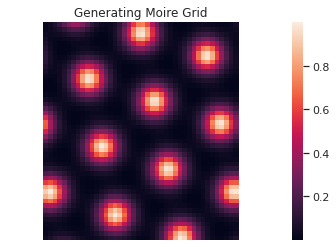

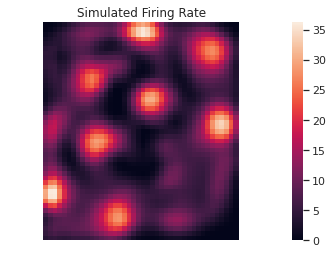

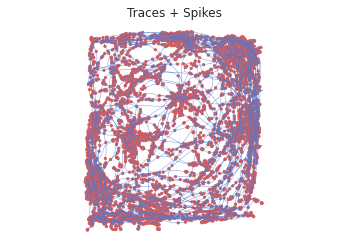

In [14]:
# define simulation params
def get_sim_moire_params(**kwargs):
    
    # default params
    width = 42
    height = 47
    seed = np.random.randint(1000)
    selection_sim_params_default = {'theta_range': [0,np.pi/3], 'l_range': [6,30], 
                            'spatial_phase_x_range': [0,width], 'spatial_phase_y_range': [0,height], 'gain_range':[0.01, 3],
                            'n_vals': 1000, 'SNR': 10.0, 'max_rate_bin': 1,
                            'width':width, 'height': height, 'seed': seed}
    
    # fill missing parameter ranges to select moire params
    selection_sim_params = {}
    if len(kwargs)>0:
        for k, v in selection_sim_params_default.items():
            if k in kwargs.keys():
                selection_sim_params[k]=kwargs[k]
            else:
                selection_sim_params[k]=v
    else:
        c = selection_sim_params_default
    
    # check if any inputs correspond to the specific moire params:
    moire_params = ['theta', 'l', 'spatial_phase_x', 'spatial_phase_y', 'gain']
    sim_params = {}
    if len(kwargs)>0:
        for k, v in kwargs.items():
            if k in moire_params:
                sim_params['sim_' + k] = v
    
    # otherwise select at random from range
    np.random.seed(selection_sim_params['seed'])
    n_vals = selection_sim_params['n_vals']
    for k in moire_params:
        if ('sim_'+k) not in sim_params.keys():
            a,b = selection_sim_params[k+'_range']
            sim_params['sim_'+k] = np.random.choice(np.linspace(a, b, n_vals))

    sim_params['seed'] = selection_sim_params['seed']
    sim_params['SNR'] = selection_sim_params['SNR']
    sim_params['max_rate_bin'] = selection_sim_params['max_rate_bin']
    
    SNR = sim_params['SNR']
    if SNR>1:
        lambda_n = 1/(SNR-1)
    else:
        lambda_n = 0
    sim_params['lambda_n'] = lambda_n
    
                       
    return sim_params, selection_sim_params

def generate_sim_moire_fr(of_dat, track_params, sim_params):
    
    # set seed.
    np.random.seed(sim_params['seed'])
    height = track_params.n_y_bins
    width = track_params.n_x_bins
    
    # extract moire grid parameters
    c = g_points(sim_params['sim_spatial_phase_x'], sim_params['sim_spatial_phase_y'])
    th = sim_params['sim_theta']
    l = sim_params['sim_l']
    gain = sim_params['sim_gain']
    lambda_n = sim_params['lambda_n']
    max_rate = sim_params['max_rate_bin']
    
    gamma = max_rate*1/(1+lambda_n)
    
    # obtain moire grid :
    x_mat,y_mat = np.meshgrid(np.arange(width), np.arange(height))
    moire_true = moire_theta_grid(env_points(x_mat.flatten(), y_mat.flatten()), c, l, th, a=gain).reshape(height,width)
    
    # obtrain true trajectory samples in bin space
    _,x_bin_idx = rs.get_discrete_data_mat(of_dat.x, bin_edges=track_params.x_bin_edges_)
    _,y_bin_idx = rs.get_discrete_data_mat(of_dat.y, bin_edges=track_params.y_bin_edges_)        
    
    # get spike_map by passing the moire true (serving as the poisson rate)
    sim_spikes = np.zeros_like(x_bin_idx)
    sim_spk_map = np.zeros((height,width))
    
    for jj in range(height):
        for ii in range(width):
            idx = np.logical_and(x_bin_idx==ii, y_bin_idx==jj)
            n_bin_occ = idx.sum()
            if n_bin_occ>track_params.occ_num_thr:
                sim_spikes[idx] = np.random.poisson( gamma*(moire_true[jj,ii]+lambda_n)*np.ones(n_bin_occ))
                sim_spk_map[jj,ii] = sim_spikes[idx].sum()

    # get occupancy map to compute firing rate
    pos_map_secs = of_dat.pos_map_secs
    pos_valid_mask = of_dat.pos_valid_mask
    sim_fr_map = np.zeros((height, width))
    sim_fr_map[pos_valid_mask] = sim_spk_map[pos_valid_mask]/pos_map_secs[pos_valid_mask]

    # smooth the map
    sim_fr_map = spatial_funcs.smooth_2d_map(sim_fr_map, n_bins=track_params.spatial_window_size, sigma=track_params.spatial_sigma)

    # obtain smooth firing rate
    sim_fr = smooth_bin_spikes(sim_spikes, track_params.time_step, temporal_smoothing=track_params.temporal_window_size)
    
    return sim_fr_map, sim_fr, sim_spikes, moire_true

sim_params, _ = get_sim_moire_params(seed=0, SNR=10, gain=5/9, l=15)
print('Simulation Parameters')
print(sim_params)
sim_fr_map, sim_fr, sim_spikes, moire_true = generate_sim_moire_fr(of_dat, track_params, sim_params)

f,ax=plot_map(moire_true)
ax.set_title('Generating Moire Grid')
ax.axis('off')

f,ax=plot_map(sim_fr_map)
ax.set_title('Simulated Firing Rate')
ax.axis('off')

f,ax=plt.subplots()
ax.plot(of_dat.x, of_dat.y, linewidth=0.5, alpha=0.7)
ax.scatter(of_dat.x, of_dat.y, s=sim_spikes*5, color='r', )
ax.axis('equal')
ax.axis('off')
ax.set_title('Traces + Spikes')

r = np.corrcoef(sim_fr_map.flatten(), moire_true.flatten())[0,1]
print(f'Map Correlation {r:0.2f}')

In [15]:
def interact_generate_sim(SNR, gain, l):
    sim_params, _ = get_sim_moire_params(seed=0, SNR=SNR, gain=gain, l=l)
    sim_fr_map, sim_fr, sim_spikes, moire_true = generate_sim_moire_fr(of_dat, track_params, sim_params)

    f,ax=plot_map(moire_true)
    ax.set_title('Generating Moire Grid')
    ax.axis('off')

    f,ax=plot_map(sim_fr_map)
    ax.set_title('Simulated Firing Rate')
    ax.axis('off')

    r = np.corrcoef(sim_fr_map.flatten(), moire_true.flatten())[0,1]
    print(f'Map Correlation {r:0.2f}')

_ =interact(interact_generate_sim, 
            l=widgets.IntSlider(min=5, max=50, step=1, value=25),
            gain=widgets.FloatSlider(min=0.0001,max=3,step=0.001, value=5/9),
            SNR=widgets.FloatLogSlider(min=0.001,max=2,step=0.005, value=20))

interactive(children=(FloatLogSlider(value=20.0, description='SNR', max=2.0, min=0.001, step=0.005), FloatSlid…

### try to find the generating model based on the simulated data

Simulation Parameters
{'sim_gain': 0.5555555555555556, 'sim_l': 20, 'sim_theta': 0.7170001251436164, 'sim_spatial_phase_x': 23.501501501501505, 'sim_spatial_phase_y': 29.59259259259259, 'seed': 0, 'SNR': 3, 'max_rate_bin': 1, 'lambda_n': 0.5}


Text(0.5, 1.0, 'Traces + Spikes')

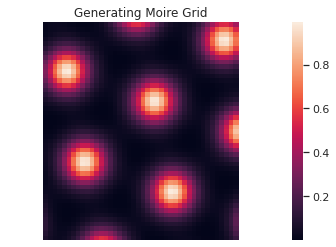

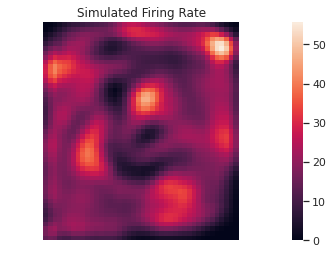

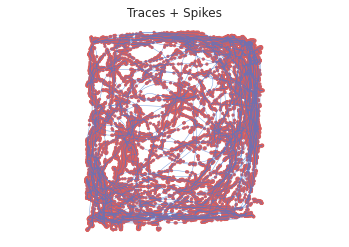

In [16]:
sim_params, _ = get_sim_moire_params(seed=0, SNR=3, prob_noise_spike=0.05, gain=5/9, l=20)
print('Simulation Parameters')
print(sim_params)
sim_fr_map, sim_fr, sim_spikes, moire_true = generate_sim_moire_fr(of_dat, track_params, sim_params)

f,ax=plot_map(moire_true)
ax.set_title('Generating Moire Grid')
ax.axis('off')

f,ax=plot_map(sim_fr_map)
ax.set_title('Simulated Firing Rate')
ax.axis('off')

f,ax=plt.subplots()
ax.plot(of_dat.x, of_dat.y, linewidth=0.5, alpha=0.7)
ax.scatter(of_dat.x, of_dat.y, s=sim_spikes*5, color='r', )
ax.axis('equal')
ax.axis('off')
ax.set_title('Traces + Spikes')


Functions to fit firing rate map to different moire grids

In [17]:
def get_moire_grid_fit_params(**kwargs):
    
    fit_params_default = {'func': rs.get_mse, 'find_max': False, 
                          'l_range': np.arange(6,33), 'theta_range': np.linspace(0,np.pi/3,60), 'gain':1}
    
    
    fit_params = {}
    for k in fit_params_default.keys():
        if k in kwargs.keys():
            fit_params[k] = kwargs[k]
        else:
            fit_params[k] = fit_params_default[k]
            
    return fit_params
            
def get_moire_grid_fit(fr_map, **kwargs):
    
    fit_params = get_moire_grid_fit_params(**kwargs)
    
    # normalize the map
    fr_map = fr_map/fr_map.max()
    
    height, width = fr_map.shape
    c = np.unravel_index(np.argmax(fr_map), fr_map.shape)
    c = env_points(c[1],c[0])
    
    x_mat,y_mat = np.meshgrid(np.arange(width), np.arange(height))
    r = env_points(x_mat.flatten(), y_mat.flatten())
    
    ls = fit_params['l_range']
    thetas = fit_params['theta_range']
    gain = fit_params['gain']
    func = fit_params['func']
    find_max = fit_params['find_max']
    
    score_mat = np.zeros((len(ls),len(thetas)))
    for ii, l in enumerate(ls):
        for jj, th in enumerate(thetas):
            moire_grid = moire_theta_grid(r, c, l, th, a=gain)
            score_mat[ii,jj] = func(fr_map.flatten(), moire_grid)
    if find_max:
        fit_idx = np.unravel_index(np.argmax(score_mat), score_mat.shape) 
    else:
        fit_idx = np.unravel_index(np.argmin(score_mat), score_mat.shape)
        
    fit_l = ls[fit_idx[0]]
    fit_theta = thetas[fit_idx[1]]
    fit_moire_grid = moire_theta_grid(r, c, fit_l, fit_theta).reshape(height,width)
    
    return fit_l, fit_theta, fit_moire_grid, score_mat


Interactive of fits

In [30]:


def interact_fit_moire_grid(SNR, gain, th, l):

    sim_params, _ = get_sim_moire_params(seed=0, SNR=SNR, gain=gain, theta=th, l=l)
    print('Simulation Parameters')
    print(sim_params)
    sim_fr_map, sim_fr, sim_spikes, moire_true = generate_sim_moire_fr(of_dat, track_params, sim_params)

    fit_params = get_moire_grid_fit_params()
    fit_l, fit_theta, fit_moire_grid, score_mat =get_moire_grid_fit(sim_fr_map, **fit_params)

    f, ax = plt.subplots(2,2,figsize=(12,12))
    ax=ax.flatten()

    _ = plot_map(moire_true, ax[0])
    ax[0].set_title(r'Generated Moire Grid: l={0}, $\theta$={1}'.format(sim_params['sim_l'], np.around(np.rad2deg(sim_params['sim_theta']),2)))
    _ = plot_map(sim_fr_map, ax[2])
    ax[2].set_title(r'Simulated FR')
    _ = plot_map(fit_moire_grid, ax[3])
    ax[3].set_title(r'Fitted Moire Grid: l={0}, $\theta$={1}'.format(fit_l, np.around(np.rad2deg(fit_theta),2)))


    ax[1].plot(of_dat.x, of_dat.y, linewidth=0.5, alpha=0.7)
    ax[1].scatter(of_dat.x, of_dat.y, s=sim_spikes*5, color='r', )
    ax[1].axis('equal')
    ax[1].axis('off')
    ax[1].set_title('Traces + Simulated Spikes')

_ =interact_manual(interact_fit_moire_grid, 
            l=widgets.IntSlider(min=5, max=50, step=1, value=25),
            th=widgets.FloatSlider(min=0, max=np.pi/3, step=0.01, value=np.pi/6),
            gain=widgets.FloatSlider(min=0.0001,max=2,step=0.001, value=5/9),
            SNR=widgets.FloatLogSlider(min=0.01,max=2,step=0.005, value=20.0))

interactive(children=(FloatLogSlider(value=20.0, description='SNR', max=2.0, min=0.01, step=0.005), FloatSlide…

## Get Encoding Model

In [19]:


def get_encoding_moire_grid_fit(spks, moire_grid, of_dat, track_params, poisson=True):
    # fit model
    _,x_bin_idx = rs.get_discrete_data_mat(of_dat.x, bin_edges=track_params.x_bin_edges_)
    _,y_bin_idx = rs.get_discrete_data_mat(of_dat.y, bin_edges=track_params.y_bin_edges_)

    # encoding vector
    X = moire_grid[y_bin_idx,x_bin_idx]
    X = np.column_stack( (np.ones(len(X)), X) )

    # get model and fit
    if poisson:
        model = lm.PoissonRegressor(alpha=0, fit_intercept=False).fit(X, spks)
    else:
        model = lm.LinearRegression(fit_intercept=False).fit(X,spks)
    coef = model.coef_

    # get predictions
    spks_hat = model.predict(X)
    
    # get_scores
    if poisson:
        R2 = rs.get_poisson_d2(spks,spks_hat)
        err = rs.get_poisson_deviance(spks, spks_hat)
        nerr = rs.get_poisson_pearson_chi2(spks, spks_hat)
    else:
        R2 = rs.get_r2(spks, spks_hat)
        err = rs.get_rmse(spks, spks_hat)
        nerr = rs.get_nrmse(spks, spks_hat)
      
    return spks_hat, coef, R2, err, nerr
    

sim_params, _ = get_sim_moire_params(seed=0, SNR=100, prob_noise_spike=0)

sim_fr_map, sim_fr, sim_spikes, moire_true = generate_sim_moire_fr(of_dat, track_params, sim_params)
fit_l, fit_theta, fit_moire_grid, score_mat = get_moire_grid_fit(sim_fr_map, func=rs.spearman, find_max=True)

sim_spikes_hat,p_coef, p_r2, p_err, p_nerr = get_encoding_moire_grid_fit(sim_spikes, fit_moire_grid, of_dat, track_params, poisson=True)
sim_spikes_hat = np.random.poisson(sim_spikes_hat)


print(f'Correlation between simulated and predicted spike trains: {rs.spearman(sim_spikes, sim_spikes_hat):0.2f}')

Correlation between simulated and predicted spike trains: 0.24


In [142]:
fr_maps.shape



(32, 47, 42)

### Putting it all together

In [20]:
def plot_map(map_, ax=None):
    if ax is None:
        f, ax = plt.subplots()
    ax = sns.heatmap(map_, ax=ax)
    ax.invert_yaxis()
    ax.axis('equal')
    return ax.figure, ax

def interact_generate_sim_and_fit(SNR, gain, l, th, loss_function):
                                  
    
    sim_params, _ = get_sim_moire_params(seed=0, SNR=SNR, gain=gain, theta=th, l=l)
    sim_fr_map, sim_fr, sim_spikes, moire_true = generate_sim_moire_fr(of_dat, track_params, sim_params)

    f, ax = plt.subplots(2,3, figsize=(18,12))
    ax = ax.flatten()
    
    _ = plot_map(moire_true, ax=ax[0])
    ax[0].set_title(r'Generated Moire Grid: l={}, $\theta={}^o$'.format(l, np.around(np.rad2deg(th),2)))
    ax[0].axis('off')

    _ = plot_map(sim_fr_map, ax=ax[1])
    ax[1].set_title('Simulated Firing Rate')
    ax[1].axis('off')

    ax[2].plot(of_dat.x, of_dat.y, linewidth=0.5, alpha=0.7)
    ax[2].scatter(of_dat.x, of_dat.y, s=sim_spikes*5, color='r', alpha=0.5 )
    ax[2].axis('equal')
    ax[2].axis('off')
    ax[2].set_title('Traces + Simulated Spikes')
    
    if loss_function is 'mse':
        func = rs.get_mse
        find_max = False
        loss_func_cmap = 'bone'
        cmap_center = None
    elif loss_function is 'nrmse':
        func = rs.get_nrmse
        find_max = False
        loss_func_cmap = 'bone'
        cmap_center = None
    elif loss_function is 'pearson':
        func = rs.pearson
        find_max = True
        loss_func_cmap = 'icefire'
        cmap_center = 0
    elif loss_function is 'spearman':
        func = rs.spearman
        find_max = True
        loss_func_cmap = 'icefire'
        cmap_center = 0
    
    # fit moire grid    
    fit_params = get_moire_grid_fit_params(func=func, find_max=find_max)
    fit_l, fit_theta, fit_moire_grid, score_mat =get_moire_grid_fit(sim_fr_map, **fit_params)
    
    _ = plot_map(fit_moire_grid,ax=ax[3])
    ax[3].set_title(r'Fitted Moire Grid: l={}, $\theta={}^o$'.format(fit_l, np.around(np.rad2deg(fit_theta),2)))
    ax[3].axis('off')
    
    df = pd.DataFrame(score_mat, columns=np.rad2deg(fit_params['theta_range']).astype(int),index=fit_params['l_range'] )
    _ = sns.heatmap(df, xticklabels=5, yticklabels=5, cmap=loss_func_cmap,center=cmap_center, ax=ax[4])
    ax[4].invert_yaxis()
    ax[4].set_title('Loss function')
    ax[4].axis('scaled')
    ax[4].yaxis.set_tick_params(rotation=0)
    ax[4].set_xlabel('Theta [deg]')
    ax[4].set_ylabel('Scaling l [bin/3cm]')
    
    
    # selected
    _th = np.argmin(abs(fit_params['theta_range']-fit_theta))
    _l = np.argmin(abs(fit_params['l_range']-fit_l))
    ax[4].scatter(_th,_l,s=50, c='blue', marker='*')
    # true
    _th = np.argmin(abs(fit_params['theta_range']-th))
    _l = np.argmin(abs(fit_params['l_range']-l))
    ax[4].scatter(_th,_l,s=50, c='green', marker='o')
    
    
    sim_fr_hat, lin_coef, r2, err, nerr = get_encoding_moire_grid_fit(sim_fr, fit_moire_grid,  of_dat, track_params, poisson=False)
    sim_spikes_hat, p_coef, p_r2, p_err, p_nerr = get_encoding_moire_grid_fit(sim_spikes, fit_moire_grid, of_dat, track_params, poisson=True)
    sim_spikes_hat = np.random.poisson(sim_spikes_hat)

    
    ax[5].plot(of_dat.x, of_dat.y, linewidth=0.5, alpha=0.7)
    ax[5].scatter(of_dat.x, of_dat.y, s=sim_spikes_hat*5, color='r', alpha=0.5)
    ax[5].axis('equal')
    ax[5].axis('off')
    ax[5].set_title('Traces + Predicted Spikes')


    r = np.corrcoef(sim_fr_map.flatten(), moire_true.flatten())[0,1]
    print(f'Map Correlation {r:0.2f}')
    print(f'Scale Error {l-fit_l} bins')
    print(f'Angle Error {np.mod(np.rad2deg(np.abs(th-fit_theta)),30):0.2f} degrees')
    print()
    print('Encoding Model Performance')
    print(f'Linear R2 = {r2}; Poisson D2 = {p_r2}')
    print(f'Linear RMSE = {err}; Poisson D = {p_err}')
    print(f'Linear NRMSE = {nerr}; Poisson PX2 = {p_nerr}')
    print(f'firing rate R = {rs.pearson(sim_fr, sim_fr_hat):0.2f} ; Spike Train R = {rs.pearson(sim_spikes, sim_spikes_hat):0.2f}')

_ =interact_manual(interact_generate_sim_and_fit, 
                   l=widgets.IntSlider(min=5, max=50, step=1, value=25),
                   th=widgets.FloatSlider(min=0, max=np.pi/3, step=0.01, value=np.pi/6),
                   gain=widgets.FloatSlider(min=0.0001,max=2,step=0.001, value=5/9),
                   SNR=widgets.FloatLogSlider(min=0.01,max=2,step=0.005, value=20.0), 
                   loss_function=['spearman', 'pearson', 'mse', 'nrmse'])

interactive(children=(FloatLogSlider(value=20.0, description='SNR', max=2.0, min=0.01, step=0.005), FloatSlide…

In [21]:

rs = reload(rs)

def vectorize_multiple_arrays(*args):
    n_args = len(args)
    index_lists = [np.arange(len(k)) for k in args]
    
    value_grid = np.array(np.meshgrid(*args))
    values = value_grid.T.reshape(-1,n_args)

    index_grid = np.array(np.meshgrid(*index_lists))
    indices = index_grid.T.reshape(-1,n_args)
    
    return values, indices

#def grid_model_performance_tests(seed=0):
loss_func = rs.spearman
find_max = True

seed=0
np.random.seed(seed)

SNRs = np.array([1.01,2,5,10,20,50]) 
ls = np.arange(5,35,5)
thetas = np.linspace(0,np.pi/3,6)

test_param_vect, indices = vectorize_multiple_arrays(SNRs, thetas, ls)
n_tests = test_param_vect.shape[0]

def simulation_worker(snr, th, l, of_dat=of_dat, track_params=track_params, seed=seed, loss_func=loss_func, find_max=find_max):

    try:
    
        sim_params, _ = get_sim_moire_params(seed=0, SNR=snr, theta=th, l=l, gain=5/9)
        sim_fr_map, sim_fr, sim_spikes, moire_true = generate_sim_moire_fr(of_dat, track_params, sim_params)

         # fit moire grid    
        fit_params = get_moire_grid_fit_params(func=loss_func, find_max=find_max, l_range=np.arange(5,35,2.5), theta_range=np.linspace(0,np.pi/3,20))
        fit_l, fit_theta, fit_moire_grid, score_mat =get_moire_grid_fit(sim_fr_map, **fit_params)

        # get predictions based on model and scores
        sim_fr_hat, lin_coef, r2, err, nerr = get_encoding_moire_grid_fit(sim_fr, fit_moire_grid,  of_dat, track_params, poisson=False)

        map_corr = rs.spearman(sim_fr_map.flatten(), fit_moire_grid.flatten() )
        fr_corr = rs.spearman(sim_fr.flatten(), sim_fr_hat.flatten())
    
        return fit_theta, fit_l, r2[0], map_corr, fr_corr

    except:  
        return np.ones(5)*np.nan
        
    
p=test_param_vect
res = Parallel(n_jobs=8)(delayed(simulation_worker)(p[i][0],p[i][1],p[i][2]) for i in range(n_tests))

# unpack results
res = np.array(res)
res_df = pd.DataFrame(columns=['SNR', 'theta', 'l', 'fit_th', 'fit_l', 'r2', 'map_r', 'fr_r'])
res_df['SNR'] = test_param_vect[:,0]
res_df['theta'] = test_param_vect[:,1]
res_df['l'] = test_param_vect[:,2]
res_df['fit_th'] = res[:,0]
res_df['fit_l'] = res[:,1]
res_df['r2'] = res[:,2]
res_df['map_r'] = res[:,3]
res_df['fr_r'] = res[:,4]


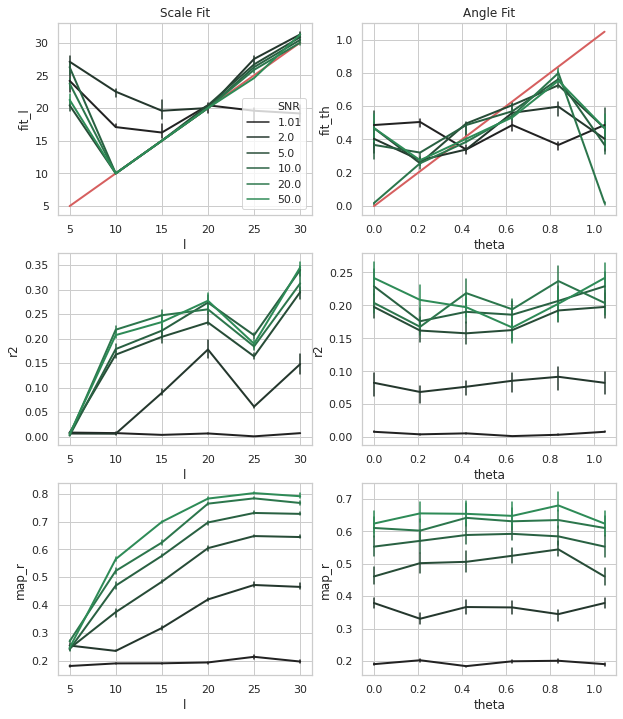

In [22]:
f,ax = plt.subplots(3,2, figsize=(10,12))

cols = sns.dark_palette("seagreen", n_colors=len(SNRs))

ax[0,0].plot(ls,ls,color='r', linewidth=2)
sns.lineplot( data=res_df,x='l',y='fit_l', hue='SNR', err_style="bars", ci=33, palette=cols, markers=True, legend='full', lw=2, ax=ax[0,0])
ax[0,0].set_title('Scale Fit')

sns.lineplot( data=res_df,x='l',y='r2', hue='SNR', err_style="bars", ci=33, palette=cols, markers=True, legend='full', lw=2, ax=ax[1,0])
ax[1,0].legend_._visible=False

sns.lineplot( data=res_df,x='l',y='map_r', hue='SNR', err_style="bars", ci=33, palette=cols, markers=True, legend='full', lw=2, ax=ax[2,0])
ax[2,0].legend_._visible=False

ax[0,1].plot(thetas, thetas, color='r', linewidth=2)
sns.lineplot( data=res_df,x='theta',y='fit_th', hue='SNR', err_style="bars", ci=33, palette=cols, markers=True, legend='full', lw=2, ax=ax[0,1])
ax[0,1].set_title('Angle Fit')
ax[0,1].legend_._visible=False

sns.lineplot( data=res_df,x='theta',y='r2', hue='SNR', err_style="bars", ci=33, palette=cols, markers=True, legend='full', lw=2, ax=ax[1,1])
ax[1,1].legend_._visible=False


sns.lineplot( data=res_df,x='theta',y='map_r', hue='SNR', err_style="bars", ci=33, palette=cols, markers=True, legend='full', lw=2, ax=ax[2,1])
ax[2,1].legend_._visible=False

### Takeaways:
From the analyses above, this is a good technique for isntances when the node-field signal is at lease 2 times greater than the througt signal (SNR>2). Moreover, scale has a big effect in these calculations, with low scales being harder to estimate correctly, even at high SNR. The phase doesn't seem to have a large effect. Interestingly, this method caps at explaining variance at ~25%, and is linearly related to the scale. This is a big number considering that it is only one parameter, however, it masks that many models were fit to obtain the moire mapping. An adjusted R2 can be obtained using the number of fits, but that would also not be completely accurate.

## Compute Grid Score

In [23]:
def acc2d(X):
    '''
    Normalized 2D autocorrelation using the FFT approach.
    '''
    n,m = X.shape
    H = np.fft.fft2(X,[2*n-1,2*m-1]) # 2d FFT w zero padding
    H /= np.sqrt( (H**2).sum() ) # variance normalization
    acc = np.fft.fftshift(np.fft.ifft2(H*np.conjugate(H))) # HxH* and shifts fft quadrants to the center
    acc = np.real(acc) # takes care of numerical errors 

    return acc


(<Figure size 864x360 with 4 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9b426cbcf8>)

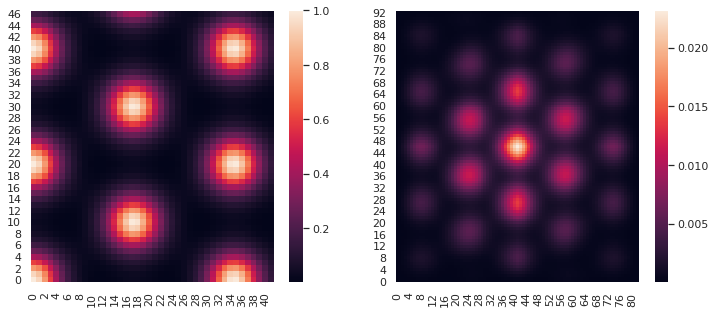

In [61]:
width = 42
height = 47
x_mat,y_mat = np.meshgrid(np.arange(width), np.arange(height))
r = env_points(x_mat.flatten(), y_mat.flatten())
c = g_points(0,0)
l = 20
th = np.pi/6
g = moire_theta_grid(r, c , l, th,)

g_map = g.reshape(height,width)

ac_g_map = acc2d(g_map)
f,ax = plt.subplots(1,2, figsize=(12,5))

plot_map(g_map,ax=ax[0])
plot_map(ac_g_map,ax=ax[1])

### find autocorrelation fields

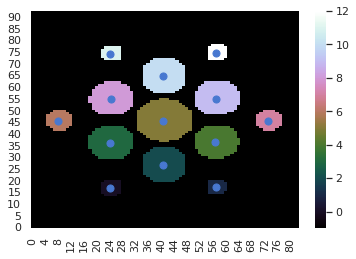

In [62]:
map_fields, n_fields = spatial_funcs.get_map_fields(ac_g_map, fr_thr=0.2)

map_fields = np.array(map_fields,dtype=int)
field_locs = ndimage.measurements.center_of_mass(ac_g_map, map_fields, np.arange(n_fields))
field_locs = np.array(field_locs)

field_mass = [np.sum(map_fields==field_id) for field_id in np.arange(n_fields)]
field_mass = np.array(field_mass)

f,ax = plt.subplots()
sns.heatmap(map_fields, cmap='cubehelix', ax=ax)
ax.invert_yaxis()
ax.scatter(field_locs[:,1],field_locs[:,0],s=50, c='b', marker='o')


In [75]:
np.sqrt(field_mass/np.pi)*2


array([ 7.04672564,  6.57952464, 14.75547228, 14.62546558, 14.31752656,
       18.01877032,  8.74038744,  8.74038744, 14.31752656, 14.62546558,
       14.75547228,  6.57952464,  7.04672564])

### get distances and mask

In [63]:
ac_map_w = map_fields.shape[1]
ac_map_h = map_fields.shape[0]
field_locs2=g_points(field_locs[:,1],field_locs[:,0])
center = g_points(ac_map_w/2, ac_map_h/2)
field_distances = field_locs2-center

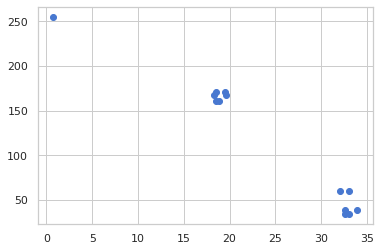

In [67]:
plt.scatter(field_distances.r, field_mass)

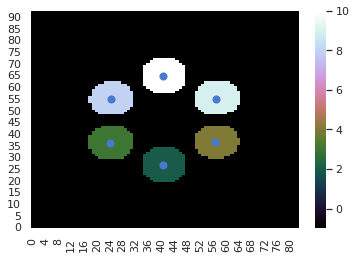

In [27]:
closest_six_fields_idx = np.argsort(field_distances.r)[1:7]

masked_fields = np.array(map_fields)
for field in range(int(n_fields)):
    if field not in closest_six_fields_idx:
        masked_fields[map_fields==field]=-1

field_locs2 = field_locs[closest_six_fields_idx]
field_mass2 = field_mass[closest_six_fields_idx]
field_distances2 = field_distances[closest_six_fields_idx]

f,ax = plt.subplots()
sns.heatmap(masked_fields, cmap='cubehelix', ax=ax)
ax.invert_yaxis()
ax.scatter(field_locs2[:,1],field_locs2[:,0], s=50, c='b', marker='o')

In [128]:
x=field_distances2.x
y=field_distances2.y


A = np.vstack([x**2, y**2]).T
b=np.ones_like(x)
r=np.linalg.lstsq(A,b)

/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys


In [130]:
#?np.linalg.lstsq
1/r[0][0],1/r[0][1]

(0.0028292543483590983, 0.0027516492811459313)

In [28]:

mean_field_dist = np.mean(field_distances2.r)
radix_range = np.array([0.5, 1.5])*np.mean(field_distances2.r)


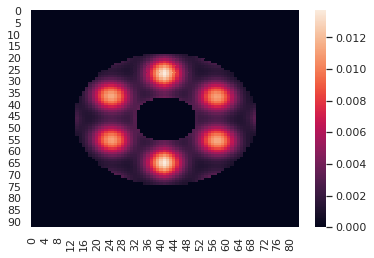

In [31]:
mask_ac = np.zeros_like(map_fields)
mask_radix_out = np.zeros_like(map_fields)
mask_radix_in = np.zeros_like(map_fields)

r,c = draw.disk((center.xy[0,1],center.xy[0,0]), radix_range[1], shape=(ac_map_h,ac_map_w))
mask_radix_out[r,c]=1

r,c = draw.disk((center.xy[0,1],center.xy[0,0]), radix_range[0], shape=(ac_map_h,ac_map_w))
mask_radix_in[r,c]=1

mask_ac = mask_radix_out-mask_radix_in

sns.heatmap(ac_g_map*mask_ac)

In [32]:
def plot_rotated_img(ang):
    unrotated_masked_ac = ac_g_map[mask_ac==1] 
    rotated_masked_ac = rotate(ac_g_map, ang)[mask_ac==1]
    print(f'Correlation to Original: {rs.pearson(unrotated_masked_ac, rotated_masked_ac)}')
    plot_map(rotate(ac_g_map*mask_ac,ang))
    
_= interact(plot_rotated_img, 
                   ang=widgets.IntSlider(min=0, max=150, step=30, value=0))

interactive(children=(IntSlider(value=0, description='ang', max=150, step=30), Output()), _dom_classes=('widge…

## get grid score

In [33]:
unrotated_masked_ac = ac_g_map[mask_ac==1] 
rotations = np.arange(30,151,30)
corrs = np.zeros(len(rotations))
for i, angle in enumerate(rotations):
    rotated_masked_ac = rotate(ac_g_map, angle)[mask_ac==1]
    corrs[i] = rs.pearson(unrotated_masked_ac, rotated_masked_ac)
    
gs = np.mean(corrs[1::2])-np.mean(corrs[::2])
print(f'Grid Score = {gs:0.3f}')

Grid Score = 1.196


### putting it together for an aribitrary fr_map:

In [27]:
def get_grid_score(rate_map, thr=0.1, non_linearity=2):
    
    radix_rel_range = np.array([0.5, 1.5])
    
    # get autocorrelation
    ac_map = acc2d((rate_map/rate_map.max())**non_linearity)
    #ac_map = (ac_map/ac_map.max())**2
   
    ac_map_w = ac_map.shape[1]
    ac_map_h = ac_map.shape[0]
    
    # get fields
    map_fields, n_fields = spatial_funcs.get_map_fields(ac_map, fr_thr=thr)
    n_fields = int(n_fields)

    # get field positions
    map_fields = np.array(map_fields,dtype=int)
    field_locs = ndimage.measurements.center_of_mass(ac_map, map_fields, np.arange(n_fields))
    field_locs = np.array(field_locs)

    field_mass = [np.sum(map_fields==field_id) for field_id in np.arange(n_fields)]
    field_mass = np.array(field_mass)

    field_locs2 = g_points(field_locs[:,1],field_locs[:,0])
    center = g_points(ac_map_w/2, ac_map_h/2)
    field_distances = field_locs2-center
    

    dist_sorted_field_idx = np.argsort(field_distances.r)
    center_field_idx = dist_sorted_field_idx[0]
    # get closest 6 fields idx
    if n_fields >= 7:
        closest_six_fields_idx = dist_sorted_field_idx[1:7]
    elif n_fields>= 3:
        closest_six_fields_idx = dist_sorted_field_idx[1:n_fields]
    else:
        print('Did not find enough fields.')
        return np.nan

    # maske the closest fields
    masked_fields = np.array(map_fields)
    for field in range(int(n_fields)):
        if field not in closest_six_fields_idx:
            masked_fields[map_fields==field]=-1

    # select fields
    field_locs2 = field_locs[closest_six_fields_idx]
    field_mass2 = field_mass[closest_six_fields_idx]
    field_distances2 = field_distances[closest_six_fields_idx]
    
    mean_field_dist = np.mean(field_distances2.r)
    estimate_angle = np.min(field_distances2.ang)
        
    radix_range = radix_rel_range*mean_field_dist
    
    # mask the region
    mask_ac = np.zeros_like(map_fields)
    mask_radix_out = np.zeros_like(map_fields)
    mask_radix_in = np.zeros_like(map_fields)

    r,c = draw.disk((center.xy[0,1],center.xy[0,0]), radix_range[1], shape=(ac_map_h,ac_map_w))
    mask_radix_out[r,c]=1

    r,c = draw.disk((center.xy[0,1],center.xy[0,0]), radix_range[0], shape=(ac_map_h,ac_map_w))
    mask_radix_in[r,c]=1

    mask_ac = mask_radix_out-mask_radix_in
    
    # rotate fields and get grid score
    unrotated_masked_ac = ac_map[mask_ac==1] 
    rotations = np.arange(30,151,30)  # rotations 30, 60, 90, 120, 150
    corrs = np.zeros(len(rotations))
    for i, angle in enumerate(rotations):
        rotated_masked_ac = rotate(ac_map, angle)[mask_ac==1]
        corrs[i] = rs.pearson(unrotated_masked_ac, rotated_masked_ac)
    gs = np.mean(corrs[1::2])-np.mean(corrs[::2])
    
    return gs, mean_field_dist, estimate_angle

width = 42
height = 47
x_mat,y_mat = np.meshgrid(np.arange(width), np.arange(height))
r = env_points(x_mat.flatten(), y_mat.flatten())
c = g_points(0,0)
l = 21
th = np.pi/4
g = moire_theta_grid(r, c , l, th,)

g_map = g.reshape(height,width)
get_grid_score(g_map, 0.1)

NameError: name 'env_points' is not defined

In [106]:
x = np.arange(10)
np.insert(x,0,1)

array([1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [139]:
def interact_generate_sim_gs(SNR, gain, l, th, thr, exp):
    sim_params, _ = get_sim_moire_params(seed=0, SNR=SNR, gain=gain, l=l, theta=th)
    sim_fr_map, sim_fr, sim_spikes, moire_true = generate_sim_moire_fr(of_dat, track_params, sim_params)

    f,ax = plt.subplots(1,3, figsize=(18,6))
    plot_map(moire_true, ax=ax[0])
    ax[0].set_title('Generating Moire Grid')
    ax[0].axis('off')

    plot_map(sim_fr_map, ax=ax[1])
    ax[1].set_title('Simulated Firing Rate')
    ax[1].axis('off')

    x = (sim_fr_map/sim_fr_map.max())**exp
    ac_map = acc2d(x)
    plot_map(ac_map, ax=ax[2])
    ax[2].set_title('Map AutoCorrelation')
    ax[2].axis('off')
    
    r = np.corrcoef(sim_fr_map.flatten(), moire_true.flatten())[0,1]
    print(f'Map Correlation {r:0.2f}')

    gs,ac_scale,ac_ang = get_grid_score(sim_fr_map, thr, exp)
    print(f'Grid Score {gs:0.2f}')
    print(f'AC Scale {ac_scale:0.2f}')
    print(f'AC Ang {np.mod(ac_ang,np.pi/3):0.2f}')
    
_ =interact(interact_generate_sim_gs, 
            l=widgets.IntSlider(min=5, max=50, step=1, value=25),
            th=widgets.FloatSlider(min=0.0001,max=np.pi/3,step=np.pi/30, value=0.1),
            gain=widgets.FloatSlider(min=0.0001,max=3,step=0.001, value=5/9),
            SNR=widgets.FloatLogSlider(min=0.001,max=2,step=0.005, value=20), 
            thr=widgets.FloatSlider(min=0.01,max=0.5,step=0.005, value=0.2),
            exp=widgets.IntSlider(min=1, max=5, step=1, value=1))


interactive(children=(FloatLogSlider(value=20.0, description='SNR', max=2.0, min=0.001, step=0.005), FloatSlid…

In [48]:
X = np.zeros((100,3))
print(X.shape, type(X))

Y = sm.add_constant(X)
print(Y.shape, type(Y))




(100, 3) <class 'numpy.ndarray'>
(100, 4) <class 'numpy.ndarray'>


## test the python implementation

In [99]:
spatial_funcs = reload(spatial_funcs)
rs = reload(rs)
x = of_dat.x
y = of_dat.y
fr_maps = session_info.get_fr_maps()
fr = session_info.get_fr()
x_bin_edges = track_params.x_bin_edges_
y_bin_edges = track_params.y_bin_edges_

out = spatial_funcs.get_grid_encoding_model(x, y, fr, fr_maps, x_bin_edges, y_bin_edges, compute_gs_sig=True, sig_alpha=0.02, n_perm=200,
                            grid_fit='auto_corr', reg_type='linear')

Computing Grid Score unit # 0
Did not find enough fields.
Computing Grid Score unit # 1
Did not find enough fields.
Computing Grid Score unit # 2
Did not find enough fields.
Computing Grid Score unit # 3
Did not find enough fields.
Computing Grid Score unit # 4
Computing Grid Score unit # 5
Computing Grid Score unit # 6
Did not find enough fields.
Computing Grid Score unit # 7
Did not find enough fields.
Computing Grid Score unit # 8
Computing Grid Score unit # 9
Computing Grid Score unit # 10
Computing Grid Score unit # 11
Computing Grid Score unit # 12
Did not find enough fields.
Computing Grid Score unit # 13
Did not find enough fields.
Computing Grid Score unit # 14
Did not find enough fields.
Computing Grid Score unit # 15
Did not find enough fields.
Computing Grid Score unit # 16
Computing Grid Score unit # 17
Computing Grid Score unit # 18
Did not find enough fields.
Computing Grid Score unit # 19
Did not find enough fields.
Computing Grid Score unit # 20
Did not find enough fie

In [100]:
out[0]

,grid_score,grid_sig,scale,phase,r2,rmse,nrmse
0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2,NaN,0.0,NaN,NaN,NaN,NaN,NaN
3,NaN,0.0,NaN,NaN,NaN,NaN,NaN
4,0.161209,0.0,27.5322,0.634644,[-0.008609581027535063],[10.418402852285068],[2.2251612482439618]
5,-0.273042,0.0,33.3461,1.4732,[-0.1266565207498751],[7.512805872006104],[1.9411218894063016]
6,NaN,0.0,NaN,NaN,NaN,NaN,NaN
7,NaN,0.0,NaN,NaN,NaN,NaN,NaN
8,0.227229,1.0,33.1023,0.209602,[-0.03389708885917053],[2.9481904899016875],[3.8837567785766938]
9,-0.183278,0.0,43.5497,0.887865,[-0.09771109524203925],[6.3078206922894475],[2.090732671149565]


In [95]:
spatial_funcs = reload(spatial_funcs)
a=spatial_funcs.permutation_test_grid_score(fr, fr_maps, x, y, x_bin_edges, y_bin_edges, n_perm=200, alpha=0.02, true_gs=out[0]['grid_score'],n_jobs=8)

In [98]:
out[0]['sig']

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     1.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
25    0.0
26    0.0
27    0.0
28    0.0
29    0.0
30    1.0
31    0.0
Name: sig, dtype: float64

## step through the process with real data

In [81]:
spatial_funcs = reload(spatial_funcs)
def plot_map(map_, ax=None):
    if ax is None:
        f, ax = plt.subplots()
    ax = sns.heatmap(map_, ax=ax)
    ax.invert_yaxis()
    ax.axis('equal')
    return ax.figure, ax

# compute grid score:
def interact_model_gs(unit):

    fr_map = fr_maps[unit]
    height,width = fr_map.shape
    
    f,ax = plt.subplots(2,2, figsize=(12,12))
    ax = ax.flatten()
    
    plot_map(fr_maps[unit], ax=ax[0])
    ax[0].set_title(f'Rate Map unit # {unit}')
    ax[0].axis('off')

    n_fr_map = (fr_map/fr_map.max())**2
    ac_map = rs.compute_autocorr_2d(n_fr_map)
    plot_map(ac_map/ac_map.max(), ax=ax[1])
    ax[1].set_title('AutoCorrelation')
    ax[1].axis('off')
    
    
    # get grid score and fit moire grid
    gs, scale, th, _ = spatial_funcs.compute_grid_score(fr_map)
    
    if ~np.isnan(gs):
        max_field_loc = np.unravel_index(np.argmax(fr_map), fr_map.shape)
        moire_mat = spatial_funcs.generate_moire_grid(width, height, [max_field_loc[1], max_field_loc[0]], scale, th)

        plot_map(moire_mat, ax=ax[2])
        ax[2].axis('off')
        ax[2].set_title('Fitted Moire Grid')
        
        r = np.corrcoef(fr_map.flatten(), moire_mat.flatten())[0,1]
        print(f'model-fr_map Correlation {r:0.2f}')
        
        # get encodign model and generate firing rate map
        fr_hat, coef, r2, err, nerr = spatial_funcs.get_encoding_map_fit(fr[unit], moire_mat, x, y, x_bin_edges, y_bin_edges, reg_type='linear')
        sm_fr_map = spatial_funcs.firing_rate_2_rate_map( fr_hat.flatten(), x, y, x_bin_edges, y_bin_edges)

        
        plot_map(sm_fr_map, ax=ax[3])
        ax[3].axis('off')
        ax[3].set_title('Model predicted rate map')
        print(f'Model R2={r2[0]:0.2f}')
        print(f'Model NRMSE={nerr[0]:0.2f}')
        
    print(f'Grid Score {gs:0.2f}')
    print(f'AC Scale {scale:0.2f}')
    print(f'AC Ang {np.mod(th,np.pi/3):0.2f}')
    
    
_ =interact(interact_model_gs, 
            unit=widgets.IntSlider(min=0, max=31, step=1, value=30))


interactive(children=(IntSlider(value=30, description='unit', max=31), Output()), _dom_classes=('widget-intera…

In [88]:
gs, _, _,_ = spatial_funcs.compute_grid_score(fr_maps[30])
gs

0.2985327784671997